# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

C:\Users\Yusheng\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [3]:
# your code here
bikes_df=pd.read_csv('data/BSS_hour_raw.csv')
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [4]:
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

In [5]:
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


<HR>
Your answer here:

***The variables temp, atemp and hum look strange by checking their averages and ranges. The variable dteday is an object, and it's not usual, some special treament might be needed.***
<HR>

#### 1.2 Notice that the variable in column ....

In [6]:
# your code here
#Convert dteday into datetime object
bikes_df['dteday']=pd.to_datetime(bikes_df['dteday'])

#### 1.3 Create three new columns ...

In [7]:
# your code here
#Add year, month and counts columns
bikes_df['year']=pd.get_dummies(pd.DatetimeIndex(bikes_df['dteday']).year)[2012]
bikes_df['month']=pd.DatetimeIndex(bikes_df['dteday']).month
bikes_df['counts']=bikes_df['casual']+bikes_df['registered']
bikes_df.tail()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
17374,2012-12-31,1,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,1,12,119
17375,2012-12-31,1,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,1,12,89
17376,2012-12-31,1,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,1,12,90
17377,2012-12-31,1,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,1,12,61
17378,2012-12-31,1,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,1,12,49


#### 1.4 Use visualization to inspect and comment on how casual rentals and registered rentals vary with the hour. 

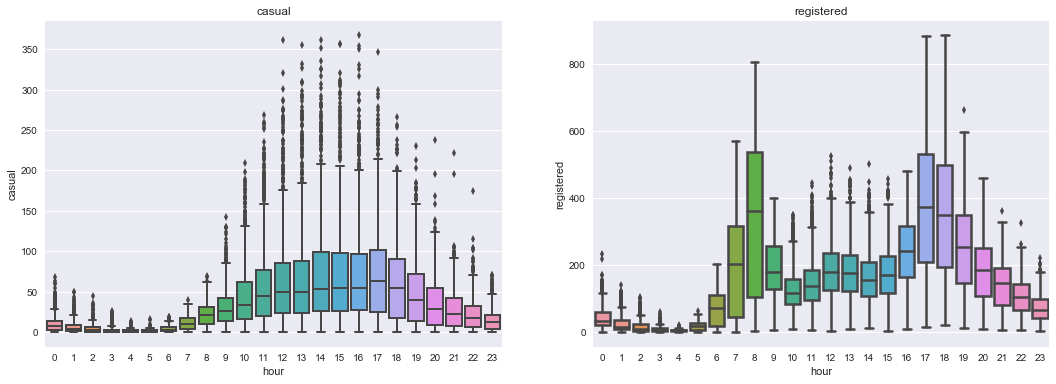

In [8]:
# your code here
#Plot casual and registered vs hour
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.boxplot(x='hour', y='casual', data=bikes_df, ax=ax1, linewidth=2)
ax1.set_title('casual')
sns.boxplot(x='hour', y='registered', data=bikes_df, ax=ax2, linewidth=2.5)
ax2.set_title('registered')

<HR>
Your answer here:

***For the casual, it shows a bell-shape from 7:00 to 23:00, but for registered, the peak time is 7-8 in the morning, and 17-18 in the afternoon. Most likely, the registered users commute to work by bikes.***
<HR>


#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

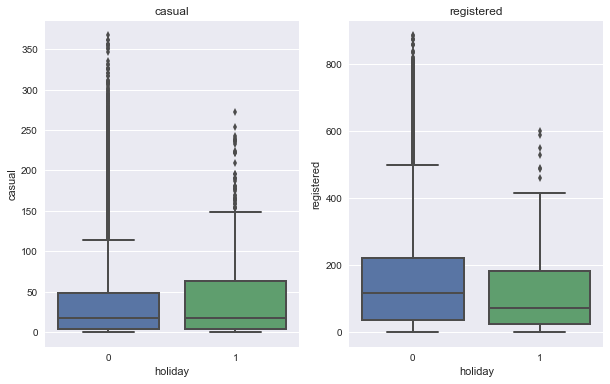

In [9]:
# your code here
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))
sns.boxplot(x='holiday', y='casual', data=bikes_df, ax=ax1, linewidth=2)
ax1.set_title('casual')
sns.boxplot(x='holiday', y='registered', data=bikes_df, ax=ax2, linewidth=2)
ax2.set_title('registered')

<HR>
Your answer here:

***In casual group, the median counts of people use bikes are similar in workday or holiday, but in registered group, more people use bikes in workday than holiday. It might suggests people use bikes as a transportation to work places, as suggested in Q1.4***
<HR>

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

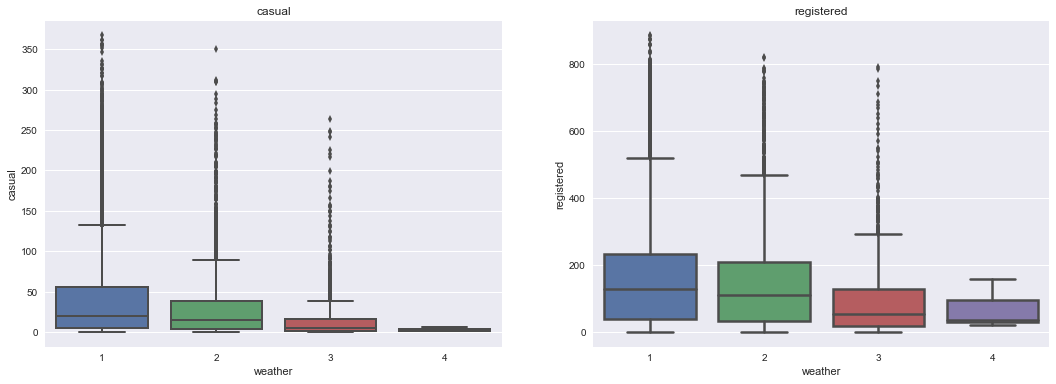

In [10]:
# your code here
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.boxplot(x='weather', y='casual', data=bikes_df, ax=ax1, linewidth=2)
ax1.set_title('casual')
sns.boxplot(x='weather', y='registered', data=bikes_df, ax=ax2, linewidth=2.5)
ax2.set_title('registered')

<HR>
Your answer here:

***Apparently, weather affected both casual and registered. Good weather, more bike renters; bad weather, less bike users.***
<HR>

<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>
#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [11]:
# your code here
bikes_by_day1 = pd.DataFrame()

In [12]:
#Subset dteday, weekday and season, store into new dataframe
bikes_by_day1['dteday'] = pd.Series(bikes_df['dteday'], index=list(range(0,len(bikes_df),24)))
bikes_by_day1['weekday']=pd.Series(bikes_df['weekday'], index=list(range(0,len(bikes_df),24)))
bikes_by_day1['season']=pd.Series(bikes_df['season'], index=list(range(0,len(bikes_df),24)))

In [13]:
#Re-index the columns and drop the old indices
bikes_by_day1=bikes_by_day1.reset_index(drop=True)

In [14]:
#Using groupby to generate new columns
bikes_df0=bikes_df.groupby('dteday').agg({
    'temp': np.mean,
    'weather': np.max,
    'atemp': np.mean,
    'windspeed': np.mean,
    'hum': np.mean,
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.sum
}).reset_index()

In [15]:
#Join a new dataframe
bikes_by_day=bikes_by_day1.set_index('dteday').join(bikes_df0.set_index('dteday')).reset_index()

In [16]:
bikes_by_day.head()

,dteday,weekday,season,temp,weather,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01,6,1,0.344167,3,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02,0,1,0.363478,3,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03,1,1,0.196364,1,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04,2,1,0.200000,2,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05,3,1,0.226957,1,0.229270,0.186900,0.436957,82,1518,1600


#### 2.2 How does season affect the number of bike ...

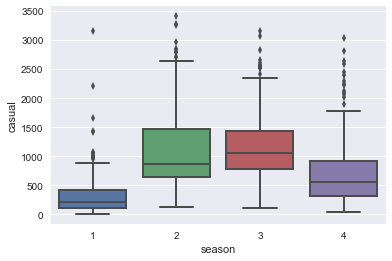

In [17]:
#Plot casual vs season
sns.boxplot(x='season', y='casual', data=bikes_by_day, linewidth=2)

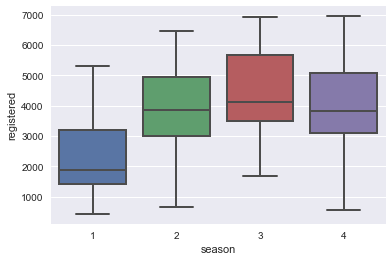

In [18]:
#Plot registered vs season
sns.boxplot(x='season', y='registered', data=bikes_by_day, linewidth=2)

<HR>
Your answer here:

***In both groups (casual and registered), there are more bikes users in summer and fall.***
<HR>

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

In [19]:
# your code here
#Get percentages of casual and registered from counts
Percentage_casual=100*bikes_by_day['casual']/bikes_by_day['counts']
Percentage_registered=100*bikes_by_day['registered']/bikes_by_day['counts']

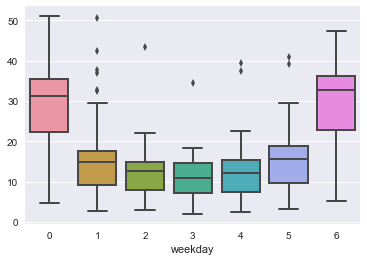

In [20]:
#Plot percentage of casual vs weekday
sns.boxplot(x=bikes_by_day['weekday'], y=Percentage_casual, linewidth=2)

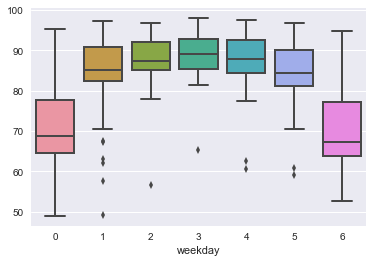

In [21]:
#Plot percentage of registered vs weekday
sns.boxplot(x=bikes_by_day['weekday'], y=Percentage_registered, linewidth=2)

<HR>
Your answer here:

***The registered users have higher percentage in weekdays compare to weekends. The casual group has opposite distribution.***
<HR>

#### 2.4 How is the distribution of total number of bike rentals different ...

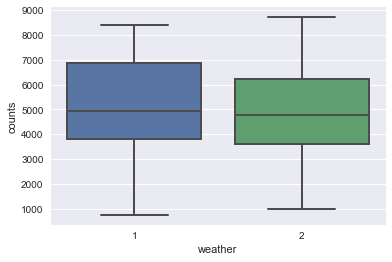

In [22]:
# your code here
sns.boxplot(x='weather', y='counts', data=bikes_by_day[bikes_by_day['weather']<3], linewidth=2)

<HR>
Your answer here:

***The weather sunny or cloudy doesn't affect the overall number of bike users.***
<HR>

#### 2.5 Visualize how the total number of rides per day ...

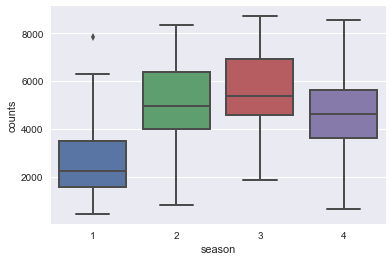

In [23]:
# your code here
#Plot the counts vs season
sns.boxplot(x='season', y='counts', data=bikes_by_day, linewidth=2)

In [24]:
#Sort the spring data by counts 
df_out=bikes_by_day[bikes_by_day['season']==1].sort_values(by='counts', ascending=False)

In [25]:
df_out

,dteday,weekday,season,temp,weather,atemp,windspeed,hum,casual,registered,counts
436,2012-03-17,6,1,0.514167,2,0.505046,0.110704,0.755833,3155,4681,7836
433,2012-03-14,3,1,0.572500,2,0.548617,0.115063,0.507083,997,5315,6312
434,2012-03-15,4,1,0.557500,2,0.532825,0.149883,0.579583,1005,5187,6192
438,2012-03-19,1,1,0.545000,2,0.532821,0.162317,0.728750,982,5171,6153
439,2012-03-20,2,1,0.560833,3,0.538533,0.121271,0.807917,1051,5042,6093
437,2012-03-18,0,1,0.472500,3,0.464000,0.126883,0.810000,2207,3685,5892
432,2012-03-13,2,1,0.565000,3,0.542929,0.236950,0.617500,762,5085,5847
427,2012-03-08,4,1,0.527500,2,0.524604,0.441563,0.567500,486,4896,5382
431,2012-03-12,1,1,0.466667,2,0.459592,0.207713,0.489167,838,4460,5298
413,2012-02-23,4,1,0.454167,3,0.444446,0.190912,0.554583,516,4546,5062


In [26]:
df_out.iloc[0]

dteday        2012-03-17 00:00:00
weekday                         6
season                          1
temp                     0.514167
weather                         2
atemp                    0.505046
windspeed                0.110704
hum                      0.755833
casual                       3155
registered                   4681
counts                       7836
Name: 436, dtype: object

<HR>
Your answer here:

***Summer and fall have more bike users than the other two seasons. Yes, there is an outlier in spring. The casual number is far more than other days. It could be a chance occurence.***
<HR>

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

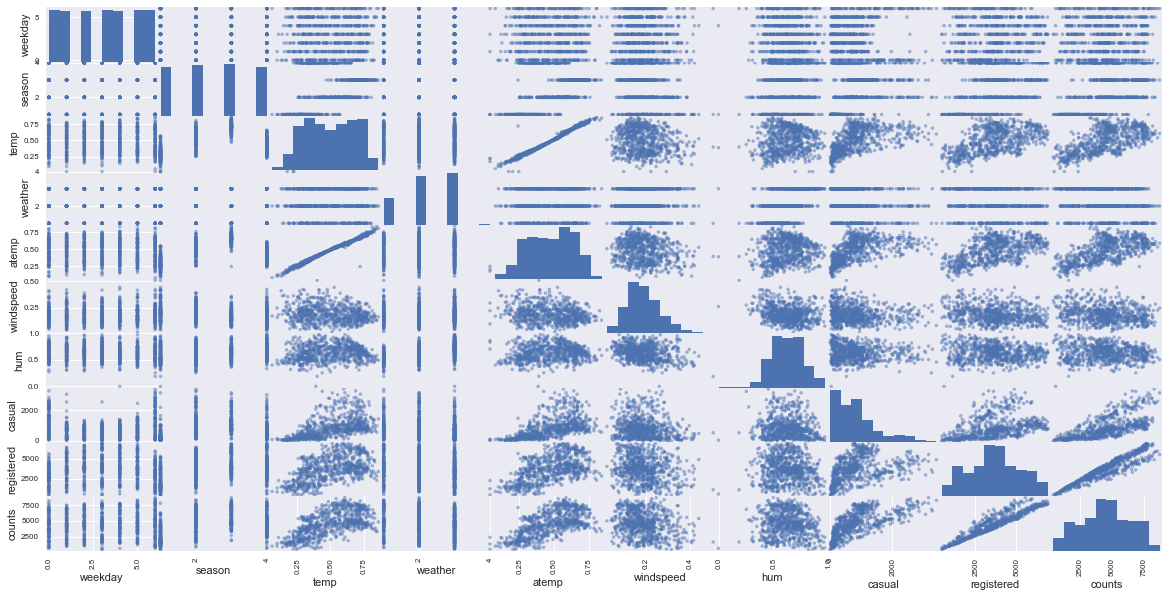

In [27]:
scatter_matrix(bikes_by_day, figsize=(20,10));

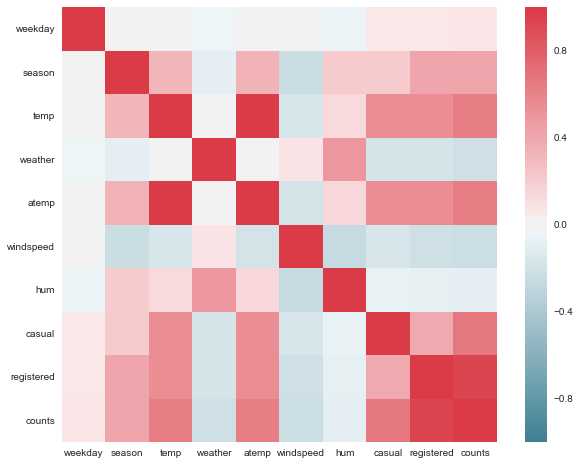

In [28]:
# your code here
#Make the heatmap on bikes_by_day correlations
f, ax = plt.subplots(figsize=(10, 8))
corr = bikes_by_day.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<HR>
Your answer here:

**By looking at the scatter matrix and heatmap, temp and atemp, registered and counts are highly correlated, respectively. The reason for temp and atemp is because temp always influences atemp. The counts was derived from registered and casual, thus the counts is strongly correlated to registered and positively correlated with casual. And, temp, atemp, casual and season are positively correlated with counts.**
<HR>

#### 3.2 Convert the categorical attributes  ....

In [29]:
bikes_by_day.head()

,dteday,weekday,season,temp,weather,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01,6,1,0.344167,3,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02,0,1,0.363478,3,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03,1,1,0.196364,1,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04,2,1,0.200000,2,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05,3,1,0.226957,1,0.229270,0.186900,0.436957,82,1518,1600


In [30]:
bikes_by_day3=pd.get_dummies(bikes_by_day, columns=['weekday', 'season',"weather"])

In [31]:
bikes_by_day3.head()

,dteday,temp,atemp,windspeed,hum,casual,registered,counts,weekday_0,weekday_1,...,weekday_5,weekday_6,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,2011-01-01,0.344167,0.363625,0.160446,0.805833,331,654,985,0,0,...,0,1,1,0,0,0,0,0,1,0
1,2011-01-02,0.363478,0.353739,0.248539,0.696087,131,670,801,1,0,...,0,0,1,0,0,0,0,0,1,0
2,2011-01-03,0.196364,0.189405,0.248309,0.437273,120,1229,1349,0,1,...,0,0,1,0,0,0,1,0,0,0
3,2011-01-04,0.200000,0.212122,0.160296,0.590435,108,1454,1562,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2011-01-05,0.226957,0.229270,0.186900,0.436957,82,1518,1600,0,0,...,0,0,1,0,0,0,1,0,0,0


#### 3.3 Split the initial bikes_df dataset...

In [32]:
# your code here
try:
    # Doesn't work: a value is missing
    bikes_train_data, bikes_test_data = train_test_split(bikes_df, test_size = 0.2, stratify=bikes_df['month'])
except:
    # Count the missing lines and drop them
    missing_rows = np.isnan(bikes_df['month'])
    print("Uh oh, {} lines missing data! Dropping them".format(np.sum(missing_rows)))
    bikes_df = bikes_df.dropna(subset=['month'])
    bikes_train_data, bikes_test_data = train_test_split(bikes_df, test_size = 0.2, stratify=bikes_df['month'])

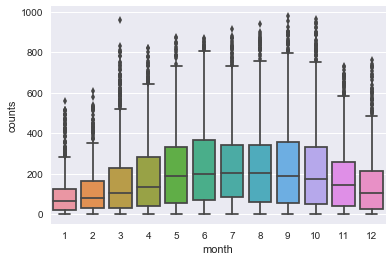

In [33]:
sns.boxplot(x='month', y='counts', data=bikes_train_data)

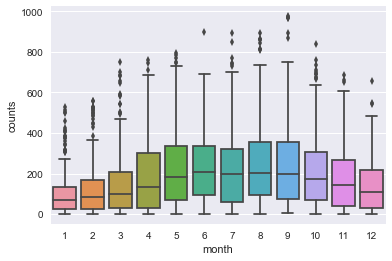

In [34]:
sns.boxplot(x='month', y='counts', data=bikes_test_data)

#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [35]:
# your code here
BSS_train=pd.read_csv('data/BSS_train.csv')
BSS_test=pd.read_csv('data/BSS_test.csv')

In [36]:
BSS_train.head()

,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
3,3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0
4,4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0


In [37]:
BSS_train = BSS_train.drop([ 'dteday', 'Unnamed: 0', 'casual', 'registered'], axis=1)
BSS_test=BSS_test.drop([ 'dteday', 'Unnamed: 0', 'casual', 'registered'], axis=1)

<HR>
Your answer here:

***Casual and registered were removed to avoid the count trivial.***
<HR>

#### 3.5 Calculate the **Pearson correlation** ....

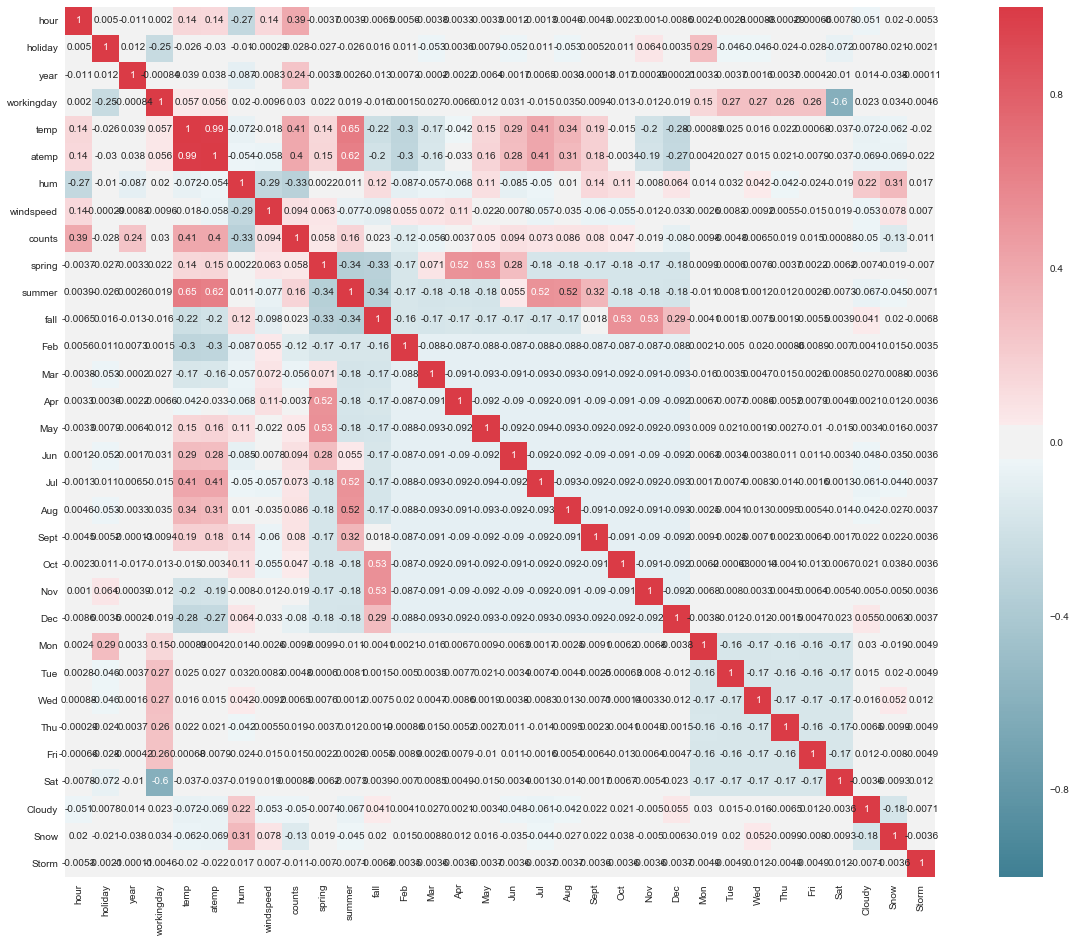

In [38]:
# your code here
f, ax = plt.subplots(figsize=(23, 16))
sns.heatmap(BSS_train.corr(), mask=np.zeros_like(BSS_train.corr(), dtype=np.bool), annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [39]:
counts_corr=BSS_train.corr().counts

In [40]:
print("The predictors having positive correlation with bike rents are: {0}".format(counts_corr[counts_corr>0].index))

The predictors having positive correlation with bike rents are: Index(['hour', 'year', 'workingday', 'temp', 'atemp', 'windspeed', 'counts',
       'spring', 'summer', 'fall', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct',
       'Wed', 'Thu', 'Fri', 'Sat'],
      dtype='object')


<HR>
Your answer here:

***By reading the heat map, the pair with colinearity more than 0.7 are temp and atemp.***
<HR>


<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [41]:
BSS_train.dtypes

hour            int64
holiday         int64
year            int64
workingday      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
counts          int64
spring          int64
summer          int64
fall            int64
Feb             int64
Mar             int64
Apr             int64
May             int64
Jun             int64
Jul             int64
Aug             int64
Sept            int64
Oct             int64
Nov             int64
Dec             int64
Mon             int64
Tue             int64
Wed             int64
Thu             int64
Fri             int64
Sat             int64
Cloudy          int64
Snow            int64
Storm           int64
dtype: object

In [42]:
#Build a design matrix for training and testing data this model
BSS_design_mat = sm.add_constant(BSS_train.drop(['counts'], axis=1))
BSS_test_mat=sm.add_constant(BSS_test.drop(['counts'], axis=1))

In [43]:
#Fit training data
BSS_ols= OLS(endog=BSS_train['counts'], exog=BSS_design_mat).fit()

In [44]:
print("Train R-squared:", BSS_ols.rsquared)

Train R-squared: 0.406538782797


In [45]:
ols_preditions = BSS_ols.predict(BSS_test_mat)
BSS_ols.rsquared=r2_score(BSS_test['counts'], ols_preditions)
print("Test R-squared:", BSS_ols.rsquared)

Test R-squared: 0.406385547571


#### 4.2 Find out which of estimated coefficients ...

In [46]:
BSS_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                        23:24:07   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
hour           7.2214      0.184     39.144      0.000       6.860       7.583
holiday      -18.0958      6.597     -2.743      0.006     -31.027      -5.165
year          76.3519      2.380     32.084      0.000      71.687      81.017
workingday    11.3178      2.751      4.114      0.000       5.926      16.710
temp         333.2482     44.162      7.546      0.000     246.684     419.812
atemp         74.6312     46.207      1.615      0.106     -15.940     165.202
hum         -205.4959      7.801    -26.343      0.000    -220.786    -190.205
windspeed     22.5168     10.753      2.094      0.036       1.439      43.595
spring        43.1541      7.417      5.818      0.000      28.615      57.693
summer        29.5426      8.773      3.367      0.001      12.346      46.739
fall          68.5953      7.492      9.156      0.000      53.911      83.280
Feb           -7.6430      5.966     -1.281      0.200     -19.336       4.050
Mar          -11.6737      6.665     -1.752      0.080     -24.737       1.390
Apr          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
May          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
Jun          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
Jul          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
Aug          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
Sept         -16.0517     10.575     -1.518      0.129     -36.780       4.676
Oct          -16.1602      9.865     -1.638      0.101     -35.497       3.177
Nov          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
Dec          -10.2043      7.614     -1.340      0.180     -25.128       4.719
Mon           -2.6601      2.978     -0.893      0.372      -8.498       3.177
Tue           -6.1425      3.208     -1.915      0.056     -12.430       0.145
Wed            2.2964      3.183      0.721      0.471      -3.943       8.536
Thu           -3.1611      3.185     -0.993      0.321      -9.404       3.082
Fri            2.8892      3.186      0.907      0.364      -3.355       9.133
Sat           14.9459      4.382      3.411      0.001       6.357      23.535
Cloudy         6.7868      2.900      2.341      0.019       1.103      12.470
Snow         -28.2859      4.819     -5.870      0.000     -37.731     -18.841
Storm         42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

#### 4.3 Make a plot of residuals of the fitted ...

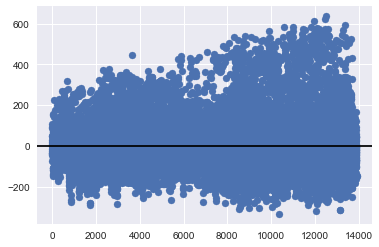

In [47]:
# your code here
#Calculate the y-predict of training data
BSS_prediction = BSS_ols.predict(BSS_design_mat)
#Calculate the residuals
residual = BSS_train['counts'] - BSS_prediction
plt.scatter(BSS_train.index, residual, label="Residual")
plt.axhline(0, color='k')

<HR>
Your answer here:
** The plot reveals a linear relationship between the predictors and response. The variance of the error terms looks contant**
<HR>

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [48]:
#Read train and test data sets
BSS_train_data=BSS_train.copy()
BSS_test_data=BSS_test.copy()

In [49]:
BSS_train.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,0,0,0,0.24,0.2879,0.81,0.0,16,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0.22,0.2727,0.80,0.0,40,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0,0,0,0.22,0.2727,0.80,0.0,32,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,0,0.24,0.2879,0.75,0.0,13,0,...,0,0,0,0,0,0,1,0,0,0
4,4,0,0,0,0.24,0.2879,0.75,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [50]:
#Seprate predictors and response variable on train data
BSS_y_train=BSS_train_data['counts']
BSS_x_train=BSS_train_data.drop(['counts'], axis=1)

In [51]:
#Seprate predictors and response variable on test data
BSS_y_test=BSS_test_data['counts']
BSS_x_test=BSS_test_data.drop(['counts'], axis=1)

In [52]:
all_predictors=list(BSS_x_train.columns.values)

In [53]:
# your code here
#Find bic
def get_bic(X_train, y_train):
    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.bic

In [54]:
#Find predictors by minimal bic
def find_predictor(dic, value):
    for ele in dic:
        if dic[ele]==np.min(value):
            return (ele, np.min(value))

In [55]:
all_predictors=list(BSS_x_train.columns.values)
total_pre=[]
bic_total=[]
kplus1=set()
output=[]
for i in range (0, len(all_predictors)-1):
    bic_dic={}
    bic_val=[]
    #Loop the rest of the predictors
    for predictor in all_predictors:
        #Add the new predictors
        kplus2=list(kplus1|set([predictor]))
        #Create design matrix
        x_train=BSS_x_train[kplus2].values
        #Get bic
        bic=get_bic(x_train, BSS_y_train)
        bic_dic[predictor]=bic
        bic_val.append(bic)
    #Get the predictors and the corresponding bic values
    total_pre.append(find_predictor(bic_dic, bic_val)[0])
    bic_total.append(find_predictor(bic_dic, bic_val)[1])

    output.append((total_pre, find_predictor(bic_dic, bic_val)[1], i))
    #Remove the predictor has been identified by the passed turn
    all_predictors=list(set(all_predictors)-set([find_predictor(bic_dic, bic_val)[0]]))
    kplus1=set(total_pre)   

In [56]:
best_predictor_set=(output[-1][0][0: np.argmin(bic_total)+1], np.min(bic_total))
print('Minimum predictor set: {}\nbic: {}\n'.format(best_predictor_set[0], best_predictor_set[1]))

Minimum predictor set: ['temp', 'hour', 'year', 'hum', 'fall', 'Jul', 'Snow', 'Aug', 'Jun', 'holiday', 'spring']
bic: 176790.38694346516



#### 5.2 Do these methods eliminate ...

<HR>
Your answer here:

***Yes, the colinear predictor was removed in this model. It's 'atemp'. Because when introducing collinearity in, the R-squared value will increase, which consequentially results in RSS and BIC increase.***
<HR>

#### 5.3 In each case, fit linear regression  ...

In [57]:
# your code here
#Calculate R2 of training data
X_train=BSS_x_train[best_predictor_set[0]].values
BSS_y_train=BSS_train_data['counts']
X_train_in = sm.add_constant(X_train)
model = sm.OLS(BSS_y_train, X_train_in).fit()
print("R2 of train data is: {}".format(model.rsquared))

R2 of train data is: 0.403827333939634


In [58]:
#Calculate R2 of testing data
BSS_y_test=BSS_test_data['counts']
BSS_x_test=BSS_test_data[best_predictor_set[0]].values
X_test_in = sm.add_constant(BSS_x_test)
test_y_predict=model.predict(X_test_in)
r2_score(BSS_y_test, test_y_predict)

0.40469087705369666

<HR>
Your answer here:

***Compared to Q4, the R-squared of test data is slightly smaller.***
<HR>

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [59]:
X_train6=BSS_x_train[best_predictor_set[0]].copy()
X_test6=BSS_test_data[best_predictor_set[0]].copy()

In [60]:
X_train6.head()

,temp,hour,year,hum,fall,Jul,Snow,Aug,Jun,holiday,spring
0,0.24,0,0,0.81,0,0,0,0,0,0,0
1,0.22,1,0,0.80,0,0,0,0,0,0,0
2,0.22,2,0,0.80,0,0,0,0,0,0,0
3,0.24,3,0,0.75,0,0,0,0,0,0,0
4,0.24,4,0,0.75,0,0,0,0,0,0,0


In [61]:
X_test6.head()

,temp,hour,year,hum,fall,Jul,Snow,Aug,Jun,holiday,spring
0,0.22,6,0,0.80,0,0,0,0,0,0,0
1,0.32,9,0,0.76,0,0,0,0,0,0,0
2,0.40,20,0,0.87,0,0,0,0,0,0,0
3,0.36,10,0,0.81,0,0,0,0,0,0,0
4,0.36,12,0,0.66,0,0,0,0,0,0,0


**The reason I added polynomial terms manually is because PolynomialFeatures and fit_transform work very slowly.**

In [62]:
#Add polynomial terms on temp
X_train6['temp2']=(X_train6['temp'])**2
X_train6['temp3']=(X_train6['temp'])**3
X_train6['temp4']=(X_train6['temp'])**4

In [63]:
#Add polynomial terms on temp
X_train6['hum2']=(X_train6['hum'])**2
X_train6['hum3']=(X_train6['hum'])**3
X_train6['hum4']=(X_train6['hum'])**4

In [64]:
X_train6.head()

,temp,hour,year,hum,fall,Jul,Snow,Aug,Jun,holiday,spring,temp2,temp3,temp4,hum2,hum3,hum4
0,0.24,0,0,0.81,0,0,0,0,0,0,0,0.0576,0.013824,0.003318,0.6561,0.531441,0.430467
1,0.22,1,0,0.80,0,0,0,0,0,0,0,0.0484,0.010648,0.002343,0.6400,0.512000,0.409600
2,0.22,2,0,0.80,0,0,0,0,0,0,0,0.0484,0.010648,0.002343,0.6400,0.512000,0.409600
3,0.24,3,0,0.75,0,0,0,0,0,0,0,0.0576,0.013824,0.003318,0.5625,0.421875,0.316406
4,0.24,4,0,0.75,0,0,0,0,0,0,0,0.0576,0.013824,0.003318,0.5625,0.421875,0.316406


In [65]:
BSS_y_train6=BSS_train_data['counts'].copy()
X_train_in6 = sm.add_constant(X_train6)
model6 = sm.OLS(BSS_y_train6, X_train_in6).fit()
print("R2 of train data is: {}".format(model6.rsquared))

R2 of train data is: 0.4147384428100821


In [66]:
#Add polynomial terms on temp
X_test6['temp2']=(X_test6['temp'])**2
X_test6['temp3']=(X_test6['temp'])**3
X_test6['temp4']=(X_test6['temp'])**4

In [67]:
#Add polynomial terms on temp
X_test6['hum2']=(X_test6['hum'])**2
X_test6['hum3']=(X_test6['hum'])**3
X_test6['hum4']=(X_test6['hum'])**4

In [68]:
X_test6.head()

,temp,hour,year,hum,fall,Jul,Snow,Aug,Jun,holiday,spring,temp2,temp3,temp4,hum2,hum3,hum4
0,0.22,6,0,0.80,0,0,0,0,0,0,0,0.0484,0.010648,0.002343,0.6400,0.512000,0.409600
1,0.32,9,0,0.76,0,0,0,0,0,0,0,0.1024,0.032768,0.010486,0.5776,0.438976,0.333622
2,0.40,20,0,0.87,0,0,0,0,0,0,0,0.1600,0.064000,0.025600,0.7569,0.658503,0.572898
3,0.36,10,0,0.81,0,0,0,0,0,0,0,0.1296,0.046656,0.016796,0.6561,0.531441,0.430467
4,0.36,12,0,0.66,0,0,0,0,0,0,0,0.1296,0.046656,0.016796,0.4356,0.287496,0.189747


In [69]:
#Calculate R2 of testing data
BSS_y_test=BSS_test_data['counts'].copy()
X_test_in6 = sm.add_constant(X_test6)
test_y_predict6=model6.predict(X_test_in6)
r2_score(BSS_y_test, test_y_predict6)

0.41603813704739134

In [70]:
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     578.8
Date:                Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                        23:24:22   Log-Likelihood:                -88210.
No. Observations:               13903   AIC:                         1.765e+05
Df Residuals:                   13885   BIC:                         1.766e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -125.4304     36.452     -3.441      0.001    -196.881     -53.980
temp         937.2133    221.921      4.223      0.000     502.218    1372.209
hour           7.1395      0.182     39.334      0.000       6.784       7.495
year          78.2899      2.378     32.916      0.000      73.628      82.952
hum          760.7217    231.176      3.291      0.001     307.586    1213.858
fall          64.2840      3.360     19.134      0.000      57.699      70.869
Jul          -81.8717      5.986    -13.677      0.000     -93.605     -70.138
Snow         -26.5196      4.694     -5.649      0.000     -35.721     -17.318
Aug          -52.0256      5.596     -9.297      0.000     -62.995     -41.056
Jun          -53.5876      5.100    -10.508      0.000     -63.584     -43.591
holiday      -36.2002      6.984     -5.184      0.000     -49.889     -22.511
spring        18.8103      3.427      5.490      0.000      12.094      25.527
temp2      -4069.0366    779.684     -5.219      0.000   -5597.323   -2540.750
temp3       8110.4425   1121.048      7.235      0.000    5913.038    1.03e+04
temp4      -4789.7471    559.745     -8.557      0.000   -5886.922   -3692.572
hum2       -2333.3183    687.241     -3.395      0.001   -3680.403    -986.233
hum3        2276.3630    859.312      2.649      0.008     591.996    3960.731
hum4        -763.1693    380.447     -2.006      0.045   -1508.897     -17.441
==============================================================================
Omnibus:                     2860.525   Durbin-Watson:                   0.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5821.298
Skew:                           1.226   Prob(JB):                         0.00
Kurtosis:                       5.009   Cond. No.                     1.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<HR>
Your answer here:

***Including additional polynomial terms with degree 4, the R-squared of test data even slightly increased compared to the test R2 value from previous question. By looking at the summary of this model, all of the polynomial terms have p-values less than 0.05, suggesting all of them are statistically significant.*** 
<HR>

#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

### Answers
#### 7
<HR>
Your report here:

**In the data exploration, we can see weather, temperature, season, month, hour and weekday are important variables to predict ridership. Bad weather dramatically reduced bike users, while clear and cloudy weather didn't affect people's interest on bikes (Figure 1). People seem more likely to ride bikes in warm weather, this consists that Summer and Fall (Figure 2), also months with relatively higher temperature have more bike users (Figure 2). Another obvious character is the registered users riding bikes to and off work. (Figure 3)**

**To increase the system revenue, the company could give discount on the rent at traffic peak time, sell month or year plan for those registered users, also introducing new styles to attract the working population. For the casual users, the company could organize activities like exploring natural trails by bikes, family bike race, or give away gift cards through lottery to those lucky bike users.**
<HR>



**Figure 1**

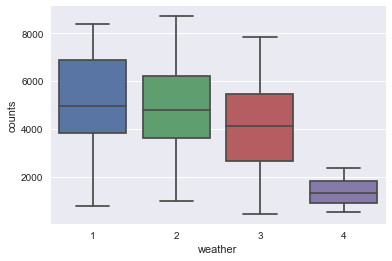

In [71]:
sns.boxplot(x='weather', y='counts', data=bikes_by_day)

**Figure 2**

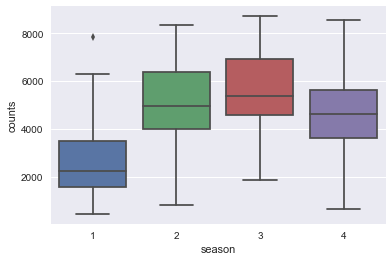

In [72]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
sns.boxplot(x='season', y='counts', data=bikes_by_day)

**Figure 3**

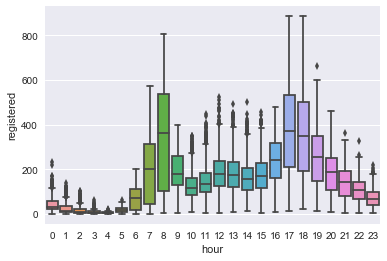

In [73]:
sns.boxplot(x='hour', y='registered', data=bikes_df)